In [176]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf
import csv
import sys
sys.path.append('/Users/arleeshelby/ManitobaWork_1374/pyNab/src')
import nabPy as Nab
sys.path.append('/Users/arleeshelby/')
from FitClass import SnCalibration
from config import conf
import Funcs
import pandas as pd
import pylab as py
np.set_printoptions(threshold=sys.maxsize)

In [243]:
with open('/Users/arleeshelby/Downloads/output1375_8.csv') as f:
    csv.DictReader(f)
    data = pd.read_csv(f)

In [244]:
pd.set_option("display.max_colwidth", 10)

In [245]:
data

,run,pixel,Bias Voltage,Proton,Proton Energy,Cd109,Sn113,Date Time [UTC],trap rise,trap length,trap decay,ecap,chi2_e,xray,chi2_x,CE,Xray,CE hist,Xray hist
0,1375,76,-320,False,0,False,True,2022-0...,1250,50,1250,[ 9.73...,0.269721,[ 1.87...,7.387315,3,5,[ 1 0...,[488 3...
1,1375,77,-320,False,0,False,True,2022-0...,1250,50,1250,[ 1.11...,0.254409,[ 7.17...,85.302869,2,5,[ 2 0...,[408 4...
2,1375,78,-320,False,0,False,True,2022-0...,1250,50,1250,[ 7.00...,0.171489,[ 3.49...,7.561129,2,5,[ 0 1...,[123 ...
3,1375,87,-320,False,0,False,True,2022-0...,1250,50,1250,[ 1.02...,0.213546,[ 1.00...,128.67...,3,5,[ 0 1...,[570 5...
4,1375,88,-320,False,0,False,True,2022-0...,1250,50,1250,[ 8.98...,0.244746,[ 1.39...,71.396528,3,5,[ 0 0...,[690 6...
5,1375,96,-320,False,0,False,True,2022-0...,1250,50,1250,[ 5.61...,0.134630,[ 1.22...,11.828209,2,4,[1 1 1...,[266 2...
6,1375,97,-320,False,0,False,True,2022-0...,1250,50,1250,[ 8.65...,0.211748,[ 1.60...,25.427016,2,5,[ 0 1...,[597 4...
7,1375,98,-320,False,0,False,True,2022-0...,1250,50,1250,[ 9.34...,0.256382,[ 1.08...,41.491225,3,4,[ 0 0...,[530 4...
8,1375,101,-320,False,0,False,True,2022-0...,1250,50,1250,[ 4.65...,0.164555,[ 2.49...,4.633468,2,5,[0 1 0...,[101 ...
9,1375,103,-320,False,0,False,True,2022-0...,1250,50,1250,[ 3.05...,0.067666,[ 4.08...,5.414419,1,5,[1 0 0...,[137 1...


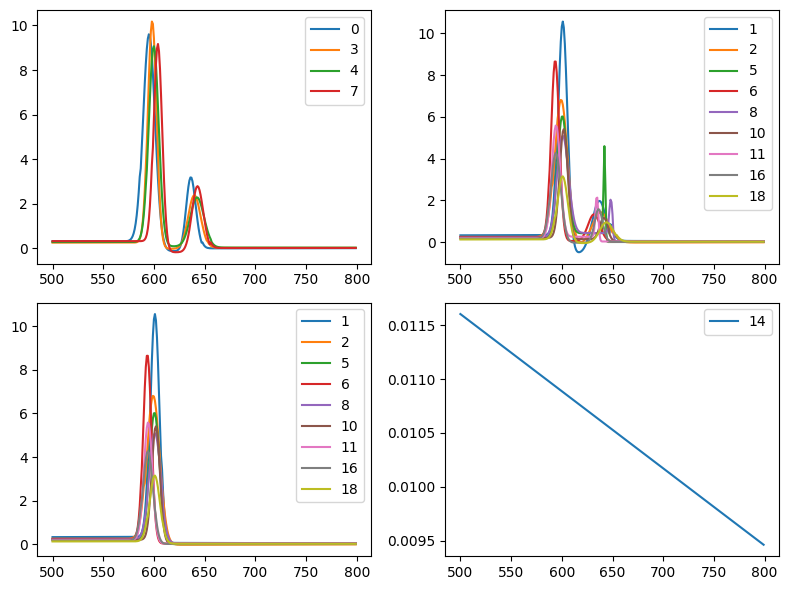

In [246]:
nrows,ncols=2,2
py.figure(figsize=(4*ncols,3*nrows))
# ax=py.subplot(nrows,ncols,cnt)

x = np.arange(500,800)
conf['xray'] = 'OFF'
for i in range(len(data)):
    if data['CE'][i]==3:
        conf['capture'] = 'three'
        Sn = SnCalibration()
        ax=py.subplot(nrows,ncols,1)
        ax.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
    if data['CE'][i]==2:
        conf['capture'] = 'two'
        Sn = SnCalibration()
        ax=py.subplot(nrows,ncols,2)
        ax.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
    if data['CE'][i]==2:
        conf['capture'] = 'one'
        Sn = SnCalibration()
        ax=py.subplot(nrows,ncols,3)
        ax.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
    if data['CE'][i]==0:
        conf['capture'] = 'zero'
        Sn = SnCalibration()
        ax=py.subplot(nrows,ncols,4)
        ax.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()

py.tight_layout()

In [249]:
conf['capture'] = 'two'
conf['xray'] = 'OFF'
Sn = SnCalibration()

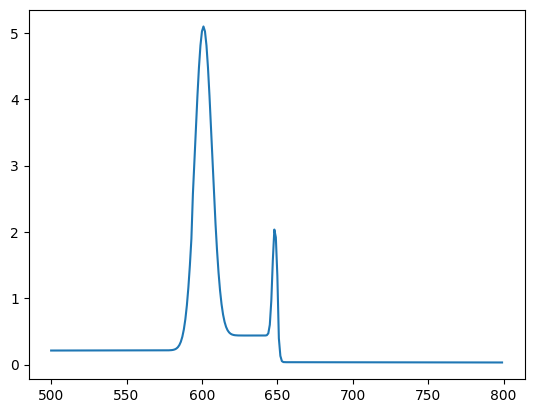

In [250]:
x = np.arange(500,800)

plt.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][8].replace('[','').replace(']','').split())),label = '%d'%i)

In [251]:
np.float64(data['ecap'][2].replace('[','').replace(']','').split())

array([ 7.00685020e+00,  5.99331574e+02,  9.03517986e+00,  1.61997220e+00,
        6.38391931e+02,  1.21088893e+01, -1.88059931e-01,  4.91201757e-01,
       -9.27688040e-05,  1.09762334e-01])

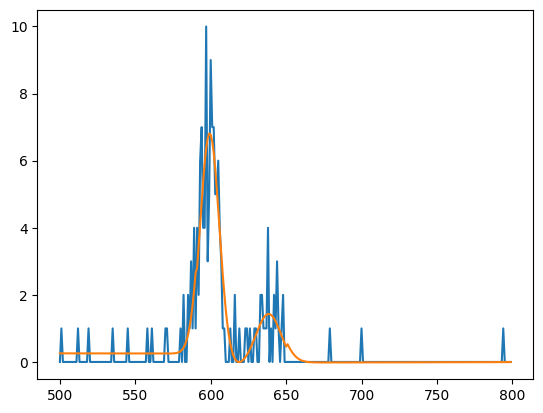

In [252]:
x = np.arange(0,300)
plt.plot(x+500,np.float64(data['CE hist'][2].replace('[','').replace(']','').split())[200:500])
x = np.arange(500,800)
plt.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][2].replace('[','').replace(']','').split())),label = '%d'%i)
plt.show()

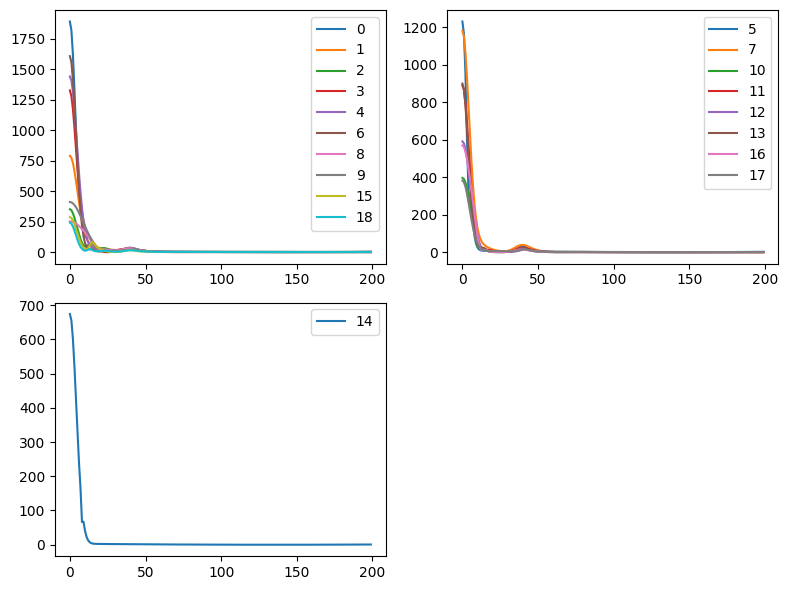

In [254]:
nrows,ncols=2,2
py.figure(figsize=(4*ncols,3*nrows))
# ax=py.subplot(nrows,ncols,cnt)

x = np.arange(0,200)
conf['capture'] = 'OFF'
for i in range(len(data)):
    if data['Xray'][i]==5:
        conf['xray'] = 'five'
        Sn = SnCalibration()
        ax=py.subplot(nrows,ncols,1)
        ax.plot(x,Sn.get_fit(x,*np.float64(data['xray'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
    if data['Xray'][i]==4:
        conf['xray'] = 'four'
        Sn = SnCalibration()
        ax=py.subplot(nrows,ncols,2)
        ax.plot(x,Sn.get_fit(x,*np.float64(data['xray'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
    if data['Xray'][i]==3:
        conf['xray'] = 'three'
        Sn = SnCalibration()
        ax=py.subplot(nrows,ncols,4)
        ax.plot(x,Sn.get_fit(x,*np.float64(data['xray'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
    if data['Xray'][i]==0:
        conf['xray'] = 'zero'
        Sn = SnCalibration()
        ax=py.subplot(nrows,ncols,3)
        ax.plot(x,Sn.get_fit(x,*np.float64(data['xray'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()

py.tight_layout()

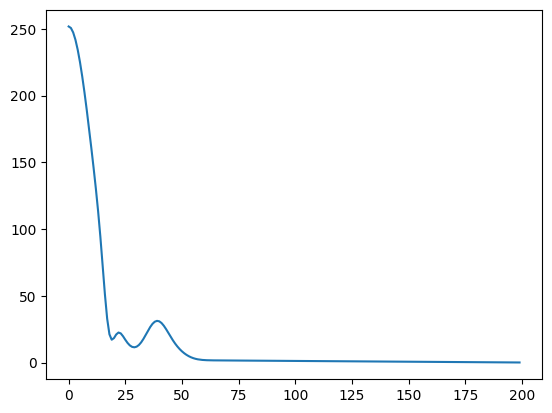

In [255]:
x = np.arange(0,200)

plt.plot(x,Sn.get_fit(x,*np.float64(data['xray'][8].replace('[','').replace(']','').split())),label = '%d'%i)
plt.show()

In [256]:
conf['capture'] = 'OFF'
conf['xray'] = 'five'
Sn = SnCalibration()

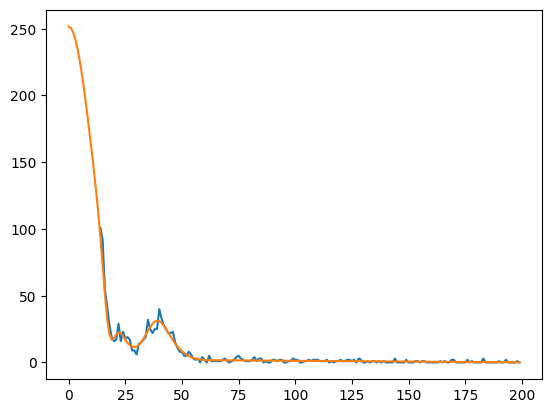

In [257]:
x = np.arange(14,200)
plt.plot(x,np.float64(data['Xray hist'][8].replace('[','').replace(']','').split()))
x = np.arange(0,200)

plt.plot(x,Sn.get_fit(x,*np.float64(data['xray'][8].replace('[','').replace(']','').split())),label = '%d'%i)
plt.show()